# 无监督学习(Unsupervised Learning)

## 关于距离的定义
- 欧几里得距离
- 曼哈顿距离
- 契比雪夫距离
- 向量内积、
- 余弦相似度

## 聚类算法的评估
- 估计聚类趋势：这一步主要检测数据分布中是否存在非随机的簇结构。可以使用霍普金斯统计量来判断数据在空间上的随机性。
- 判断数据簇数：通过手肘法、Gap Statistic方法来获取数据簇数。
- 测定聚类质量：
    - 轮廓系数
    - 均方根标准差
    - R方
    - 改进的Hubert统计

## K-means
模型输入：
- k：簇的数量
- D：包含n个样本的数据集

输出：
- k的簇

方法：
- 归一化和离群点处理
- 任意选取k个点作为簇的中心点(质心)
- repeat
    - 遍历每个点，计算他们到k个质心得距离，并将距离最近的点聚为一簇
    - 重新计算均值，作为每个簇心得质心
- until 簇中心不再发生变化

优点：
- 时间复杂度是O(nkt)，t为迭代次数，接近线性
- 当结果簇紧凑时，簇与簇之间明显分离时，它的效果较好

缺点：
- 该算法经常终止在局部最优解
- 对噪声和离群点敏感
- 不能发现非凸形状的簇
- 事先给定k，不容易给出最佳k
- 初始的簇的中心对簇类结果影响很大

优化思路：
- 数据归一化和离群点处理
- 合理选取k值，使用“手肘法”选取最佳k值（不自动化）
- Gap Stastistic（自动化）
- 采用核函数（拟合非线性的簇）
- 改进的算法K-means++/ISODATA

### K-meas的计算变化图

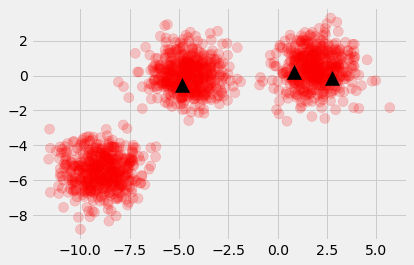

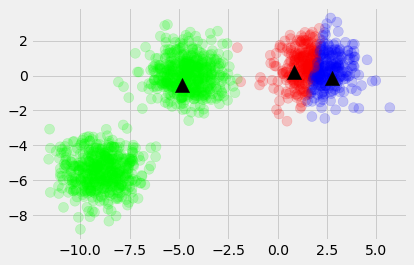

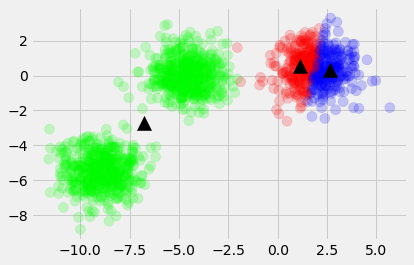

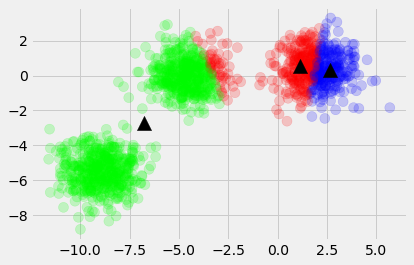

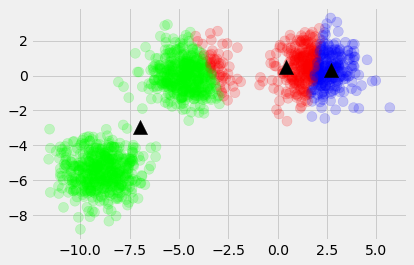

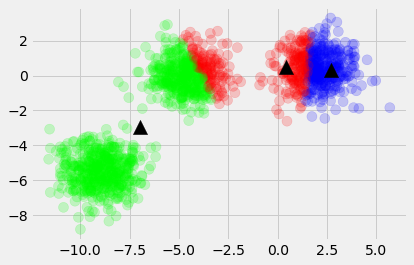

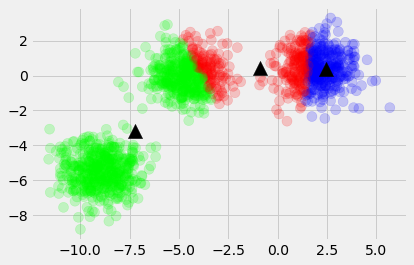

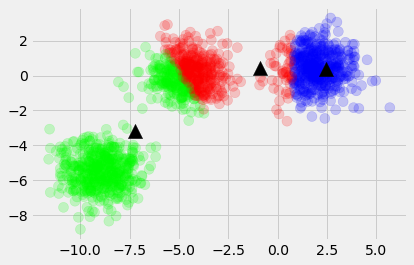

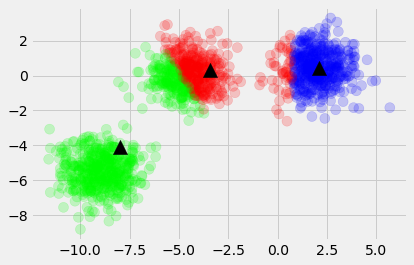

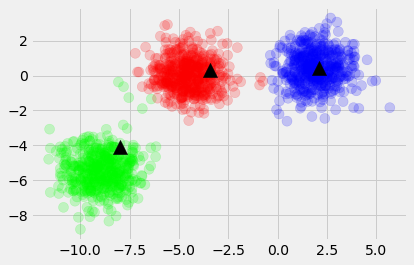

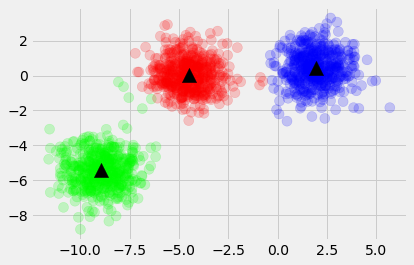

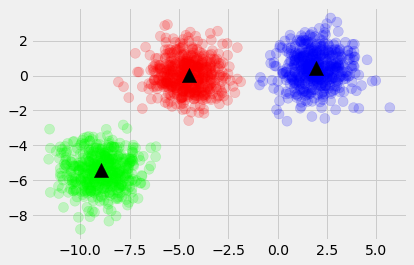

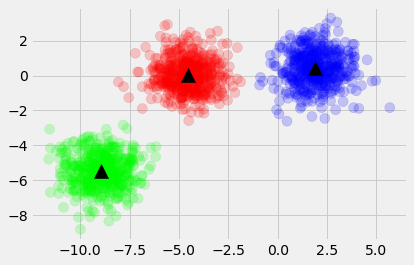

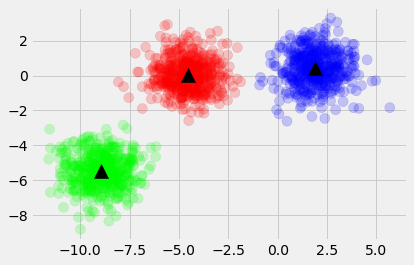

In [7]:
import matplotlib.pyplot as plt
from scipy.linalg import norm
import numpy.matlib as ml
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_blobs
np.random.seed(0)
def kmeans(X, k, observer=None, threshold=1e-15, maxiter=300, style="kmeans"):
    N = len(X)
    labels = np.zeros(N, dtype=int)
    
    centers = X[np.random.choice(len(X), k)]
    itr = 0


    def calc_J():
        """
        计算所有点距离和
        """
        sums = 0
        for i in range(N):
            sums += norm(X[i]-centers[labels[i]])
        return sums
 
    def distmat(X, Y):
        """
        计算距离
        """
        n = len(X)
        m = len(Y)
        xx = ml.sum(X*X, axis=1)
        yy = ml.sum(Y*Y, axis=1)
        xy = ml.dot(X, Y.T)
        return np.tile(xx, (m, 1)).T+np.tile(yy, (n, 1)) - 2*xy
 
    Jprev = calc_J()
    while True:
        #绘图
        observer(itr, labels, centers)

        dist = distmat(X, centers)
        labels = dist.argmin(axis=1)
        #再次绘图
        observer(itr, labels, centers)
        # 重新计算聚类中心
        if style=="kmeans":
            for j in range(k):
                idx_j = (labels == j).nonzero()
                centers[j] = X[idx_j].mean(axis=0)
        elif style=="kmedoids":
            for j in range(k):
                idx_j = (labels == j).nonzero()
                distj = distmat(X[idx_j], X[idx_j])
                distsum = ml.sum(distj, axis=1)
                icenter = distsum.argmin()
                centers[j] = X[idx_j[0][icenter]]

        J = calc_J()
        itr += 1
 
        if Jprev-J < threshold:
            """
            当中心不再变化停止迭代
            """
            break
        Jprev = J
        if itr >= maxiter:
            break

        
 
if __name__ == '__main__':
    # 加载数据点
    X, _ = make_blobs(n_samples=1500, random_state=170)
 
    def observer(iter, labels, centers):
        colors = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
 
        # 绘制数据点
        data_colors=[colors[lbl] for lbl in labels]
        plt.scatter(X[:, 0], X[:, 1], c=data_colors, s=100, alpha=0.2, marker="o")
        # 绘制中心
        plt.scatter(centers[:, 0], centers[:, 1], s=200, c='k', marker="^")
 
        plt.show()
 
    kmeans(X, 3, observer=observer)

### K-means对初始值敏感

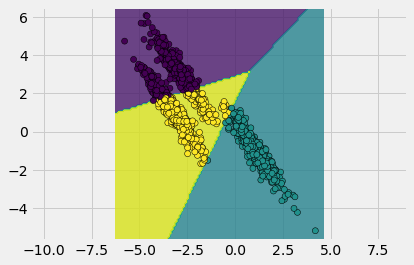

In [8]:
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.cluster import KMeans
import numpy as np
centers = [[0, 1], [-1, -1], [1, -1]]
X, y = make_blobs(n_samples=1500, random_state=170)
trs = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X = np.dot(X, trs)    
clt = KMeans(3)
clt.fit(X)

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
#调整图片风格
mpl.style.use('fivethirtyeight')
#定义xy网格，用于绘制等值线图
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
#预测可能性
Z = clt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
yp = clt.predict(X)
plt.contourf(xx, yy, Z, alpha=.8)
#绘制散点图
plt.scatter(X[:, 0], X[:, 1], c=yp, edgecolors='k')
plt.axis("equal")
plt.show()

### K-means无法聚类非凸形状

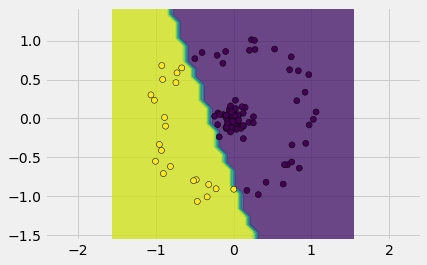

In [9]:
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.cluster import KMeans

X, y = make_circles(noise=0.1, factor=0.1, random_state=1)

clt = KMeans(n_clusters=2, random_state=1)
clt.fit(X)

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
#调整图片风格
mpl.style.use('fivethirtyeight')
#定义xy网格，用于绘制等值线图
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
#预测可能性
Z = clt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
yp = clt.predict(X)
plt.contourf(xx, yy, Z, alpha=.8)
#绘制散点图
plt.scatter(X[:, 0], X[:, 1], c=yp, edgecolors='k')
plt.axis("equal")
plt.show()

## K-medoids

改进K-means：
- 对于离群值敏感
- 核心是将原来计算簇的平均值作为质心，改变为距离质心的曼哈顿距离之和最小

输入：
- k：簇的数量
- D：包含n个样本的数据集
- 相似度衡量函数

输出：
- k的簇

方法：
- 随机选取K个质心的值 （质心必须是某些样本点的值，而不是任意值）
- 计算各个点到质心的距离 
- 将点的类划分为离他最近的质心，形成K个cluster 
- repeat
    - 根据分类好的cluster，在每个cluster内重新计算质心：
    - 计算cluster内所有样本点到其中一个样本点的曼哈顿距离和(绝对误差)
    - 选出使cluster绝对误差最小的样本点作为质心
- until(迭代次数/小于指定的误差)

优点：
- 对于离群值不敏感

缺点：
- 计算量大，O(k(n-k)2）

## 层次聚类(Hierarchical)

改进K-means：
- 无法聚类非凸形状

输入：
- k：簇的数量
- D：包含n个样本的数据集
- 相似度衡量函数

输出：
- k的簇

自下向上的方法：
- 初始化每个样本为一个簇
- repeat
    - 计算样本两两之间的距离
    - 通过相似性度量函数，找出最相似的两个簇进行合并
- unti(簇数为k)

自上而下的方法：
- 初始化所有样本为一个簇
- repeat
    - 计算样本两两之间的距离
    - 计算当前所有簇的损失函数，选择损失最大的簇进行二分
    - 计算该簇下两点间距离，选择簇中最远的两个点作为类中心将簇进行二分;
- until(簇数为k)


优点：
- 可以聚非凸的簇
- 可以产生有结构性语义的簇

缺点：
- 凝聚和分裂后不可逆

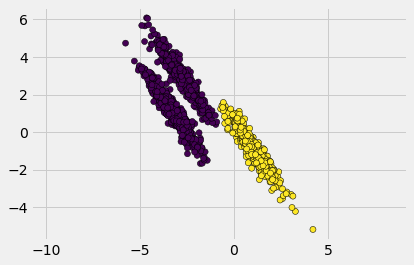

In [15]:
# 自下而上
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt

centers = [[0, 1], [-1, -1], [1, -1]]
X, y = make_blobs(n_samples=1500, random_state=170)
trs = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X = np.dot(X, trs)    
clt = AgglomerativeClustering(linkage="ward")
yp = clt.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=yp, edgecolors='k')
plt.axis("equal")
plt.show()

## DBSCAN

输入：
- 半径Eps
- 最小簇包含样本的数目MinPts

方法：

输出：
- k的簇

方法：
- 遍历数据集中的每个样本
- repeat
    - 如果该样本已经归属某个簇或者标记为噪音则跳过该样本
    - 检查该样本的邻域Eps，如果邻域内的样本小于MinPts，则将该样本记为噪音
    - 如果不是噪音则标记当前样本为核心点p，并建立新簇C, 并检查p的邻域，如果邻域内的样本不属于任何簇或噪音，则将其加入到C簇  
- until(遍历完成)
- [动态实例](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

优点：
- 相比K-Means，DBSCAN 不需要预先声明聚类数量。
- 可以对任意形状的稠密数据集进行聚类，相对的，K-Means之类的聚类算法一般只适用于凸数据集。
- 可以在聚类的同时发现异常点，对数据集中的异常点不敏感。
- 聚类结果没有偏倚，相对的，K-Means之类的聚类算法初始值对聚类结果有很大影响。

缺点：
- 当空间聚类的密度不均匀、聚类间距差相差很大时，聚类质量较差，因为这种情况下参数MinPts和Eps选取困难。
- 如果样本集较大时，聚类收敛时间较长，此时可以对搜索最近邻时建立的KD树或者球树进行规模限制来改进。
- 在两个聚类交界边缘的点会视乎它在数据库的次序决定加入哪个聚类，幸运地，这种情况并不常见，而且对整体的聚类结果影响不大（DBSCAN*变种算法，把交界点视为噪音，达到完全决定性的结果。）
- 调参相对于传统的K-Means之类的聚类算法稍复杂，主要需要对距离阈值eps，邻域样本数阈值MinPts联合调参，不同的参数组合对最后的聚类效果有较大影响。

In [19]:
# -*- coding: utf-8 -*-
import numpy as np
 
def distance(data):
    '''计算样本点之间的距离
    :param data(mat):样本
    :return:dis(mat):样本点之间的距离
    '''
    m, n = np.shape(data)
    dis = np.mat(np.zeros((m, m)))
    for i in range(m):
        for j in range(i, m):
            # 计算i和j之间的欧式距离
            tmp = 0
            for k in range(n):
                tmp += (data[i, k] - data[j, k]) * (data[i, k] - data[j, k])
            dis[i, j] = np.sqrt(tmp)
            dis[j, i] = dis[i, j]
    return dis
 
def find_eps(distance_D, eps):
    '''找到距离≤eps的样本的索引
    :param distance_D(mat):样本i与其他样本之间的距离
    :param eps(float):半径的大小
    :return: ind(list):与样本i之间的距离≤eps的样本的索引
    '''
    ind = []
    n = np.shape(distance_D)[1]
    for j in range(n):
        if distance_D[0, j] <= eps:
            ind.append(j)
    return ind
  
def dbscan(data, eps, MinPts):
    '''DBSCAN算法
    :param data(mat):需要聚类的数据集
    :param eps(float):半径
    :param MinPts(int):半径内最少的数据点数
    :return:
        types(mat):每个样本的类型：核心点、边界点、噪音点
        sub_class(mat):每个样本所属的类别
    '''
    m = np.shape(data)[0]
    # 在types中，1为核心点，0为边界点，-1为噪音点
    types = np.mat(np.zeros((1, m)))
    sub_class = np.mat(np.zeros((1, m)))
    # 用于判断该点是否处理过，0表示未处理过
    dealt = np.mat(np.zeros((m, 1)))
    # 计算每个数据点之间的距离
    dis = distance(data)
    # 用于标记类别
    number = 1
 
    # 对每一个点进行处理
    for i in range(m):
        # 找到未处理的点
        if dealt[i, 0] == 0:
            # 找到第i个点到其他所有点的距离
            D = dis[i,]
            # 找到半径eps内的所有点
            ind = find_eps(D, eps)
            # 区分点的类型
            # 边界点
            if len(ind) > 1 and len(ind) < MinPts + 1:
                types[0, i] = 0
                sub_class[0, i] = 0
            # 噪音点
            if len(ind) == 1:
                types[0, i] = -1
                sub_class[0, i] = -1
                dealt[i, 0] = 1
            # 核心点
            if len(ind) >= MinPts + 1:
                types[0, i] = 1
                for x in ind:
                    sub_class[0, x] = number
                # 判断核心点是否密度可达
                while len(ind) > 0:
                    dealt[ind[0], 0] = 1
                    D = dis[ind[0],]
                    tmp = ind[0]
                    del ind[0]
                    ind_1 = find_eps(D, eps)
 
                    if len(ind_1) > 1:  # 处理非噪音点
                        for x1 in ind_1:
                            sub_class[0, x1] = number
                        if len(ind_1) >= MinPts + 1:
                            types[0, tmp] = 1
                        else:
                            types[0, tmp] = 0
 
                        for j in range(len(ind_1)):
                            if dealt[ind_1[j], 0] == 0:
                                dealt[ind_1[j], 0] = 1
                                ind.append(ind_1[j])
                                sub_class[0, ind_1[j]] = number
                number += 1
 
    # 最后处理所有未分类的点为噪音点
    ind_2 = ((sub_class == 0).nonzero())[1]
    for x in ind_2:
        sub_class[0, x] = -1
        types[0, x] = -1
 
    return types, sub_class

## 高斯混合分布(GMM)

[GMM和EM算法讲解](https://zhuanlan.zhihu.com/p/45793456)

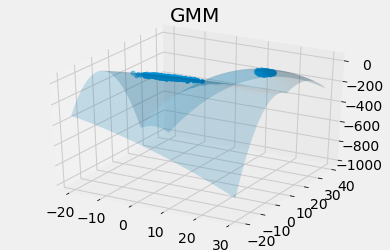

In [20]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import matplotlib.animation as animation
import numpy as np
from matplotlib.colors import LogNorm
from sklearn import mixture
mpl.style.use('fivethirtyeight')
n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components

clf = mixture.GaussianMixture(max_iter=300, n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T



Z = clf.score_samples(XX)
Z = Z.reshape(X.shape)
fig = plt.figure()
ax = fig.gca(projection='3d')
CS = ax.plot_surface(X, Y, Z, alpha=0.2)
ax.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('GMM')
plt.axis('tight')
plt.show()

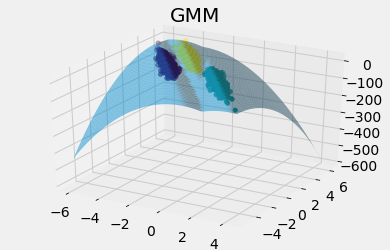

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import matplotlib.animation as animation
import numpy as np
from matplotlib.colors import LogNorm
from sklearn import mixture
from sklearn.datasets import make_moons, make_circles, make_blobs
mpl.style.use('fivethirtyeight')
n_samples = 300

centers = [[0, 1], [-1, -1], [1, -1]]
X, y = make_blobs(n_samples=1500, random_state=170)
trs = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X = np.dot(X, trs)   

clf = mixture.GaussianMixture(max_iter=300, n_components=3, covariance_type='full')
clf.fit(X)

# display predicted scores by the model as a contour plot
x_min, x_max = X[:, 0].min() - .2, X[:, 0].max() + .2
y_min, y_max = X[:, 1].min() - .2, X[:, 1].max() + .2
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = clf.score_samples(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

YY = clf.predict(X)
YY = np.array(YY)
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(xx, yy, Z, alpha=0.5)

ax.scatter(X[:, 0], X[:, 1], c=YY)

plt.title('GMM')
plt.axis('tight')
plt.show()

## LDA主题模型